# Agent performance analysis

`````{margin}
````{dropdown} Necessary imports
```{code-block} python
from copy import deepcopy
import toolz
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from myst_nb import glue

from colosseum import config
from colosseum.agent.mdp_models.bayesian_models import RewardsConjugateModel
from colosseum.agent.mdp_models.bayesian_models import TransitionsConjugateModel
from colosseum.experiment.agent_mdp_interaction import MDPLoop
from colosseum.agent.agents.episodic import QLearningEpisodic, PSRLEpisodic
from colosseum.mdp.river_swim import RiverSwimEpisodic
from colosseum.utils import make_mdp_spec
from colosseum.utils.acme.in_memory_logger import InMemoryLogger
from colosseum.analysis.visualization import plot_MDP_graph
from colosseum.analysis.visualization import plot_MCGraph

sns.set_theme()
config.enable_verbose_logging()
```
````
`````

In [1]:
from copy import deepcopy
import toolz
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from myst_nb import glue

from colosseum import config
from colosseum.agent.mdp_models.bayesian_models import RewardsConjugateModel
from colosseum.agent.mdp_models.bayesian_models import TransitionsConjugateModel
from colosseum.experiment.agent_mdp_interaction import MDPLoop
from colosseum.agent.agents.episodic import QLearningEpisodic, PSRLEpisodic
from colosseum.mdp.river_swim import RiverSwimEpisodic
from colosseum.utils import make_mdp_spec
from colosseum.utils.acme.in_memory_logger import InMemoryLogger
from colosseum.analysis.visualization import plot_MDP_graph
from colosseum.analysis.visualization import plot_MCGraph

sns.set_theme()
config.enable_verbose_logging()

2022-10-15 16:38:26.492698: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-15 16:38:26.577732: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2022-10-15 16:38:26.932811: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-10-15 16:38:26.932850: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-10-15 16:38:26.932854: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


````{margin}
```{hint}
The analysis of the agents' performances in the tutorial is meant to test ideas and develop novel algorithms.
The [_Benchmark analysis_ tutorial](../tutorials/benchmark-visualization.md) explains how to analyze and compare algorithms at scale.
```
````

{{col}} implements several performance indicators for analysing and comparing agents' performances.
After describing each of them, we will present examples on how to compare the performances of two agents for a fixed MDP, and the performances of a single agent across different MDPs.
We distinguish between these two kinds of analysis as {{col}} provides indicators specialized for the two cases, which accounts for transition kernel and reward kernel differences.



<h3>Indicators</h3>

**Reward-based indicators**  
The $\texttt{cumulative_reward}$ measures the empirical cumulative reward the agent obtains while interacting with the MDP, while the $\texttt{cumulative_expected_reward}$ indicator measures the expected average reward for the current policy of the agent at fixed intervals and cumulates them.
The main difference between the two is that the former is empirical, whereas the latter provides a thorough evaluation of the agent by considering its policy across the entire state-action space.

**Regret-based indicators**  
The $\texttt{cumulative_regret}$ computes the expected regret for the policy of the agent at a fixed interval and cumulates them.
In the episodic setting, it is computed as the difference of starting state values between the optimal policy and the agent's policy with each starting state weighted according to its probability.

**Baseline indicators**  
The $\texttt{cumulative_expected_reward}$ and the $\texttt{cumulative_regret}$ indicators are also available for the uniformly randomly acting policy, the optimal policy, and the worst-performing policy.
Such indicators provide a point of reference when analysing the performance of the agents.

All the previously mentioned indicators, including the baselines, have corresponding normalized versions in the range $[0, T]$, where $T$ is the total number of time steps,
The normalized is carried out by considering the values of the indicators for the optimal policy and the worst performing policy in the given MDPs.
The normalized version of the indicators is well suited to compare across different MDPs as it accounts for differences in transition and reward kernels.

**Computation cost**  
The $\texttt{steps_per_second}$ indicators measures the average number of time steps.

You can retrieve the available indicators in the code with the [``MDPLoop``](../pdoc_files/colosseum/experiment/agent_mdp_interaction.html#MDPLoop.get_available_indicators()) function.

<h3>Fixed MDP comparison</h3>

Below, we compare the performance of the $\texttt{q-learning}$ agent with the performance of the $\texttt{PSRL}$ in the $\texttt{RiverSwim}$ MDP of size four and with a probability of $0.01$ of the action of the agent being substituted with a uniform random one in the episodic setting for a total of $20\ 000$ time steps.
As the MDP is fixed, we can compare the performances without necessarily using the normalized versions of the indicators.

In [2]:
seed = 42
optimization_horizon = 20_000
log_every=200

# Instantiate the MDP
mdp = RiverSwimEpisodic(seed=0, size=4, p_rand=0.01)

# Instantiate the agents
q_learning_agent = QLearningEpisodic(
    mdp_specs=make_mdp_spec(mdp),
    seed=seed,
    optimization_horizon=optimization_horizon,
    c_1 = 0.95,
    p = 0.05
)
psrl_agent = PSRLEpisodic(
    mdp_specs=make_mdp_spec(mdp),
    seed=seed,
    optimization_horizon=optimization_horizon,
)

# q-learning  interaction
loop_ql = MDPLoop(mdp, q_learning_agent)
loop_ql.run(T=optimization_horizon, log_every=log_every)

# PSRL interaction
loop_psrl = MDPLoop(mdp, psrl_agent)
loop_psrl.run(T=optimization_horizon, log_every=log_every)

Experiment loop QLearningEpisodic@RiverSwimEpisodic:   0%|                                                                                                                                                                                                                           | 0/20000 [00:00<?, ?it/s]

Experiment loop QLearningEpisodic@RiverSwimEpisodic: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [00:00<00:00, 20780.54it/s, is_training=True, Instantaneous normalized regret=5.03e-5]

Experiment loop PSRLEpisodic@RiverSwimEpisodic:   0%|                                                                                                                                                                                                                                | 0/20000 [00:00<?, ?it/s]

Experiment loop PSRLEpisodic@RiverSwimEpisodic: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [00:02<00:00, 7470.94it/s, is_training=True, Instantaneous normalized regret=4.92e-5]

(-1,
 {'steps': 19999,
  'cumulative_regret': 4225.644016265869,
  'cumulative_reward': 874.5449999999255,
  'cumulative_expected_reward': 700.3522977232933,
  'normalized_cumulative_regret': 17156.504815413944,
  'normalized_cumulative_reward': 3550.7334375633927,
  'normalized_cumulative_expected_reward': 2843.49498493578,
  'random_cumulative_regret': 4583.808854222298,
  'random_cumulative_expected_reward': 342.1875089406967,
  'random_normalized_cumulative_regret': 18610.68712311847,
  'random_normalized_cumulative_expected_reward': 1389.3128768815302,
  'worst_cumulative_regret': 4925.996363162994,
  'worst_cumulative_expected_reward': 0.0,
  'worst_normalized_cumulative_regret': 20000.0,
  'worst_normalized_cumulative_expected_reward': 0.0,
  'optimal_cumulative_expected_reward': 4925.996363162994,
  'optimal_normalized_cumulative_expected_reward': 20000.0,
  'steps_per_second': 7467.005062636687})

**Cumulative reward**

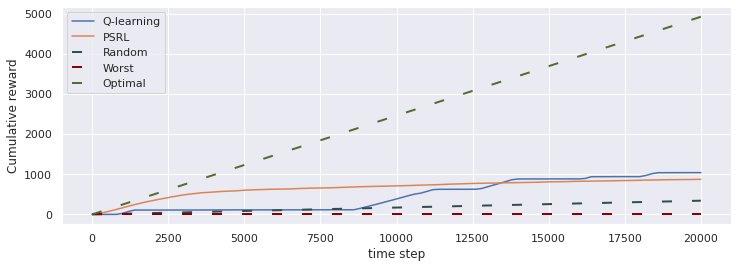

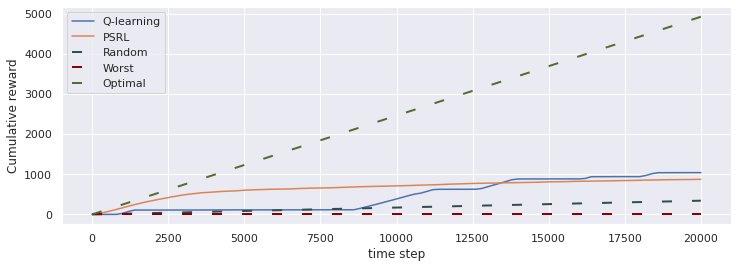

In [3]:
# Create the shared axis for the plot
fig, ax = plt.subplots(1, 1, figsize=(12, 4))

# Plot the cumulative reward of the q-learning agent without the baselines
loop_ql.plot("cumulative_reward", ax, baselines=[])

# Plot the cumulative reward of the PSRL agent, including the baselines this time
loop_psrl.plot("cumulative_reward", ax)

# Display the figure
glue("cumulative_reward", fig, display=False)

````{div} full-width
```{glue:figure} cumulative_reward
```
````


**Cumulative expected reward**

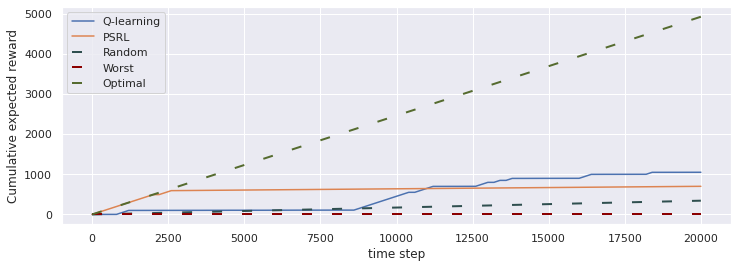

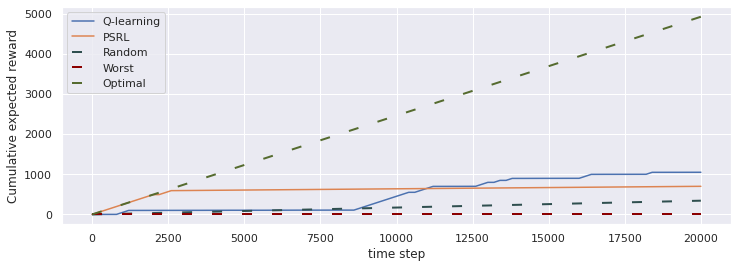

In [4]:
fig1, ax = plt.subplots(1, 1, figsize=(12, 4))
loop_ql.plot("cumulative_expected_reward", ax, baselines=[])
loop_psrl.plot("cumulative_expected_reward", ax)
glue("cumulative_expected_reward", fig1, display=False)

````{div} full-width
```{glue:figure} cumulative_expected_reward
```
````

**Cumulative regret**

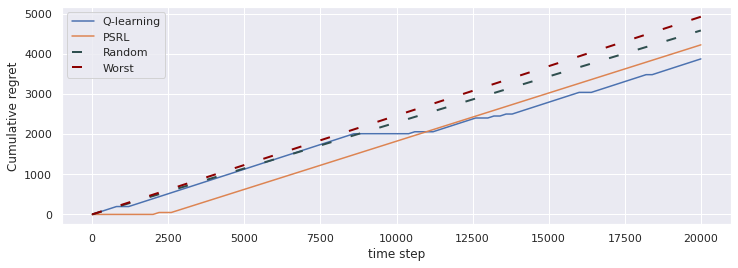

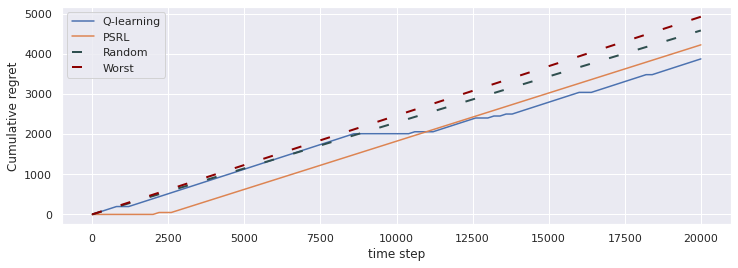

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
loop_ql.plot("cumulative_regret", ax, baselines=[])
loop_psrl.plot("cumulative_regret", ax)
glue("cumulative_regret", fig, display=False)
plt.show()

````{div} full-width
```{glue:figure} cumulative_regret
```
````

**Steps per second**

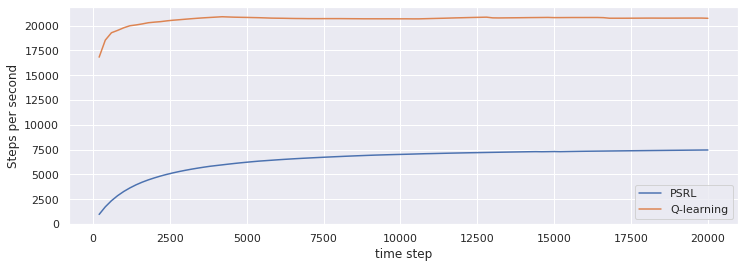

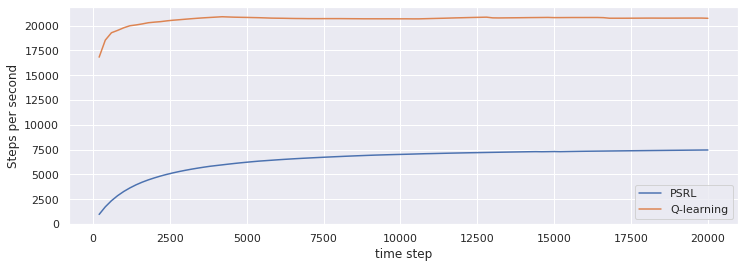

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
loop_psrl.plot("steps_per_second", ax)
loop_ql.plot("steps_per_second", ax)
glue("steps_per_second", fig, display=False)
plt.show()

````{div} full-width
```{glue:figure} steps_per_second
```
````

<h3>Fixed agent class comparison</h3>

Below, we compare the performance of the $\texttt{QLearning}$ agent in the $\texttt{RiverSwim}$ MDP of size four and ten with the probability of the action of the agent being substituted with a uniform random one of $0.01$ in the episodic setting for a total of $20\ 000$ time steps.
In this case, the use of the normalized versions of the indicators allows making comparisons on identical scales.

In [7]:
seed = 42
optimization_horizon = 20_000

# Instantiate the MDPs
mdp_short = RiverSwimEpisodic(seed=0, size=4, p_rand=0.01)
mdo_long = RiverSwimEpisodic(seed=0, size=10, p_rand=0.01)

# Instantiate the agent
agent_for_short = QLearningEpisodic(
    mdp_specs=make_mdp_spec(mdp_short),
    seed=seed,
    optimization_horizon=optimization_horizon,
    c_1 = 0.95,
    p = 0.05
)
agent_for_long = QLearningEpisodic(
    mdp_specs=make_mdp_spec(mdo_long),
    seed=seed,
    optimization_horizon=2000,
    c_1 = 0.95,
    p = 0.05
)

# Short Riverswim interaction
loop_short = MDPLoop(mdp_short, agent_for_short)
loop_short.run(T=optimization_horizon, log_every=200)

# Long Riverswim interaction
loop_long = MDPLoop(mdo_long, agent_for_long)
loop_long.run(T=optimization_horizon, log_every=200)

Experiment loop QLearningEpisodic@RiverSwimEpisodic:   0%|                                                                                                                                                                                                                           | 0/20000 [00:00<?, ?it/s]

Experiment loop QLearningEpisodic@RiverSwimEpisodic: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [00:00<00:00, 20856.81it/s, is_training=True, Instantaneous normalized regret=5.03e-5]

Experiment loop QLearningEpisodic@RiverSwimEpisodic:   0%|                                                                                                                                                                                                                           | 0/20000 [00:00<?, ?it/s]

Experiment loop QLearningEpisodic@RiverSwimEpisodic: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [00:00<00:00, 21118.19it/s, is_training=True, Instantaneous normalized regret=5.05e-5]

(-1,
 {'steps': 19999,
  'cumulative_regret': 1912.162219285965,
  'cumulative_reward': 1.03,
  'cumulative_expected_reward': 1.0480104689486325,
  'normalized_cumulative_regret': 19989.044032243146,
  'normalized_cumulative_reward': 10.76724304326996,
  'normalized_cumulative_expected_reward': 10.955517894234225,
  'random_cumulative_regret': 1890.4173038899899,
  'random_cumulative_expected_reward': 22.792968899011612,
  'random_normalized_cumulative_regret': 19761.730644841406,
  'random_normalized_cumulative_expected_reward': 238.26935515859353,
  'worst_cumulative_regret': 1913.2102727890015,
  'worst_cumulative_expected_reward': 0.0,
  'worst_normalized_cumulative_regret': 20000.0,
  'worst_normalized_cumulative_expected_reward': 0.0,
  'optimal_cumulative_expected_reward': 1913.2102727890015,
  'optimal_normalized_cumulative_expected_reward': 20000.0,
  'steps_per_second': 21092.311159412344})

**Normalized cumulative reward**

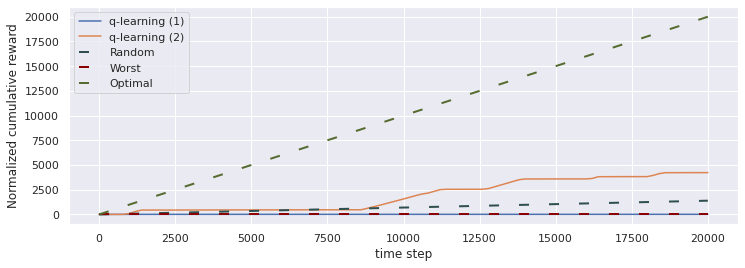

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
loop_long.plot("normalized_cumulative_reward", ax, label="q-learning (1)", baselines=[])
loop_short.plot("normalized_cumulative_reward", ax, label="q-learning (2)")
glue("normalized_cumulative_reward", fig, display=False)
plt.close()

````{div} full-width
```{glue:figure} normalized_cumulative_reward
```
````

**Normalized cumulative expected reward**

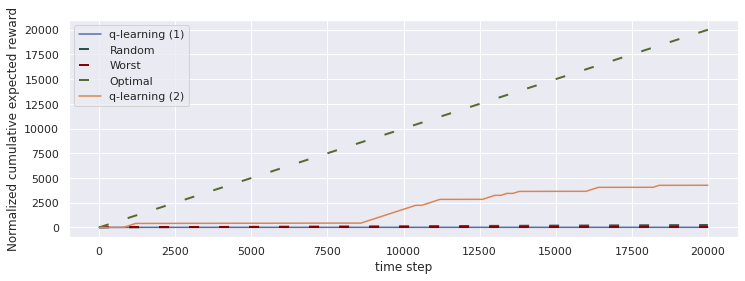

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
loop_long.plot("normalized_cumulative_expected_reward", ax, label="q-learning (1)")
loop_short.plot("normalized_cumulative_expected_reward", ax, label="q-learning (2)", baselines=[])
glue("normalized_cumulative_expected_reward", fig, display=False)
plt.close()

````{div} full-width
```{glue:figure} normalized_cumulative_expected_reward
```
````

**Normalized cumulative regret**

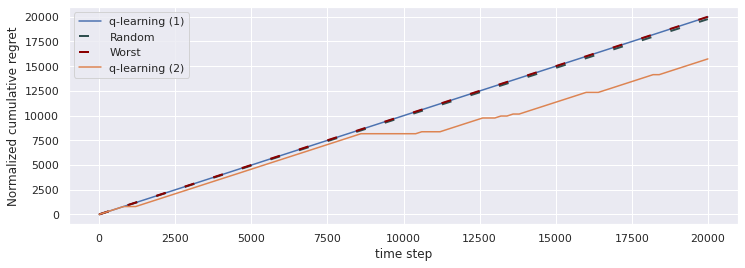

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
loop_long.plot("normalized_cumulative_regret", ax, label="q-learning (1)")
loop_short.plot("normalized_cumulative_regret", ax, label="q-learning (2)", baselines=[])
glue("normalized_cumulative_regret", fig, display=False)
plt.close()

````{div} full-width
```{glue:figure} normalized_cumulative_regret
```
````

**Steps per second**

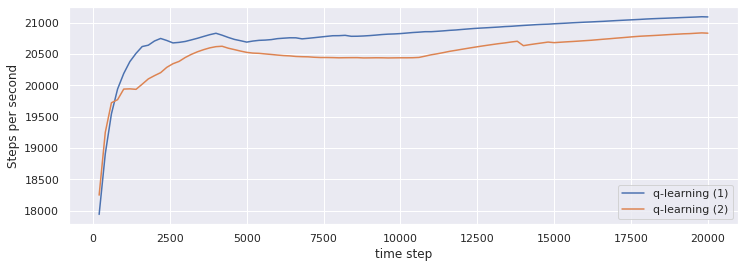

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
loop_long.plot("steps_per_second", ax, label="q-learning (1)")
loop_short.plot("steps_per_second", ax, label="q-learning (2)")
glue("normalized_steps_per_second", fig, display=False)
plt.close()

````{div} full-width
```{glue:figure} normalized_steps_per_second
```
````